<div class="alert alert-info">

Launch in Binder                                      [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master/?filepath=doc%2FNotebooks%2FExamples.ipynb)

<!-- Or launch an [Rstudio instance](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?urlpath=rstudio?filepath=doc%2FNotebooks%2FExamples.ipynb)
 -->
</div>

# Examples


In this project, UNSEEN-open is applied to assess two extreme events in 2020: February 2020 UK precipitation and the 2020 Siberian heatwave.

## Siberian Heatwave
The 2020 Siberian heatwave was a prolonged event that consistently broke monthly temperature the records. We show a gif of the temperature rank within the observations from 1979-2020, see [this section](Global_monthly_temperature_records_ERA5.ipynb) for details.
- Rank 1 mean highest on record
- Rank 2 means second highest
- etc..

![Siberian Temperature records 2020](../../graphs/Siberia_Animation_01.gif "Records2020")

*Could such an event be anticipation with UNSEEN?* 

*And to what extend can we expect changes in the frequency of occurrence and magnitude of these kind of events?*
[This attribution study](https://www.worldweatherattribution.org/siberian-heatwave-of-2020-almost-impossible-without-climate-change/) by World Weather Attribution (WWA) has shown that the event was made much more likely (600x) because of human induced climate change but also that the event was a very rare event within our present climate.



### Download

The main functions to retrieve all forecasts (SEAS5) and reanalysis (ERA5) are `retrieve_SEAS5` and `retrieve_ERA5`. We want to download 2m temperature, for the March-May target months over the Siberian domain. By default, the hindcast years of 1981-2016 are downloaded for SEAS5. We include the years 1981-2020. The folder indicates where the files will be stored, in this case outside of the UNSEEN-open repository, in a 'Siberia_example' directory. For more explanation, see [retrieve](1.Download/1.Retrieve.ipynb).

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
os.chdir(os.path.abspath('../../'))

import src.cdsretrieve as retrieve
import src.preprocess as preprocess

import numpy as np
import xarray as xr

In [2]:
retrieve.retrieve_SEAS5(
    variables=['2m_temperature', '2m_dewpoint_temperature'],
    target_months=[3, 4, 5],
    area=[70, -11, 30, 120],
    years=np.arange(1981, 2021),
    folder='../Siberia_example/SEAS5/')

In [3]:
retrieve.retrieve_ERA5(variables=['2m_temperature', '2m_dewpoint_temperature'],
                       target_months=[3, 4, 5],
                       area=[70, -11, 30, 120],
                       folder='../Siberia_example/ERA5/')

### Preprocess

In the preprocessing step, we first merge all downloaded files into one xarray dataset, then take the spatial average over the domain and a temporal average over the MAM season. Read the docs on [preprocessing](2.Preprocess/2.Preprocess.ipynb) for more info. 

The merged xarray dataset looks like this:

In [4]:
SEAS5_Siberia = preprocess.merge_SEAS5(folder = '../Siberia_example/SEAS5/', target_months = [3,4,5])
SEAS5_Siberia

Lead time: 02
1
12


,Array,Chunk
Bytes,387.52 MB,3.31 MB
Shape,"(3, 117, 51, 41, 132)","(1, 3, 51, 41, 132)"
Count,887 Tasks,117 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,387.52 MB,3.31 MB
Shape,"(3, 117, 51, 41, 132)","(1, 3, 51, 41, 132)"
Count,887 Tasks,117 Chunks
Type,float32,numpy.ndarray


And for ERA5:

In [5]:
ERA5_Siberia = xr.open_mfdataset('../Siberia_example/ERA5/ERA5_????.nc',combine='by_coords') ## open the data
ERA5_Siberia

,Array,Chunk
Bytes,2.73 MB,64.94 kB
Shape,"(126, 41, 132)","(3, 41, 132)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.73 MB,64.94 kB
Shape,"(126, 41, 132)","(3, 41, 132)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray


Then we calculate the day-in-month weighted seasonal average: 

In [6]:
SEAS5_Siberia_weighted = preprocess.season_mean(SEAS5_Siberia, years = 39)
ERA5_Siberia_weighted = preprocess.season_mean(ERA5_Siberia, years = 42)

And we select the 2m temperature, and take the average over a further specified domain. This is a simple average, a area-weighed average is more appropriate, since grid cell area decreases with latitude, see [preprocess](2.Preprocess/2.Preprocess.ipynb). 

In [14]:
SEAS5_Siberia_events_zoomed = (
    SEAS5_Siberia_weighted['t2m'].sel(
        latitude=slice(70, 50),  
        longitude=slice(65, 120)).  
    mean(['longitude', 'latitude']))

SEAS5_Siberia_events_zoomed_df = SEAS5_Siberia_events_zoomed.to_dataframe()

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [18]:
ERA5_Siberia_events_zoomed = (
    ERA5_Siberia_weighted['t2m'].sel(  # Select 2 metre temperature
        latitude=slice(70, 50),        # Select the latitudes
        longitude=slice(65, 120)).    # Select the longitude
    mean(['longitude', 'latitude']))

ERA5_Siberia_events_zoomed_df = ERA5_Siberia_events_zoomed.to_dataframe()

### Evaluate


<div class="alert alert-info">

Note

From here onward we use R and not python!
    
We switch to R since we believe R has a better functionality in extreme value statistics. 

</div>

In [1]:
setwd('../..')
getwd()
SEAS5_Siberia_events_zoomed_df <- read.csv("Data/SEAS5_Siberia_events_zoomed.csv", stringsAsFactors=FALSE)
ERA5_Siberia_events_zoomed <- read.csv("Data/ERA5_Siberia_events_zoomed.csv", stringsAsFactors=FALSE)

[1] "C:/Users/Timo/OneDrive - Loughborough University/GitHub/UNSEEN-open"

In [2]:
require(UNSEEN)

Loading required package: UNSEEN



Warning message:
"Removed 2756 rows containing non-finite values (stat_boxplot)."


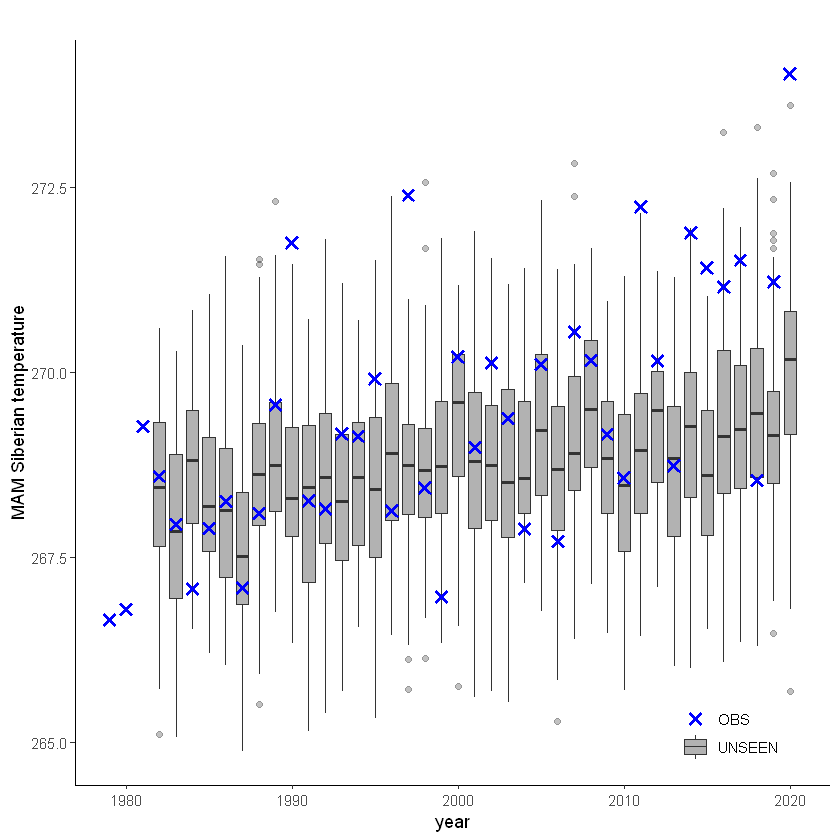

In [3]:
unseen_timeseries(
    ensemble = SEAS5_Siberia_events_zoomed_df,
    obs = ERA5_Siberia_events_zoomed,
    ensemble_yname = "t2m",
    ensemble_xname = "year",
    obs_yname = "t2m",
    obs_xname = "year",
    ylab = "MAM Siberian temperature")

## UK Precipitation
February average precipitation was the highest on record in the UK: with what frequency of occurrence can February extreme precipitation events such as the 2020 event be expected?


In [6]:
retrieve.retrieve_ERA5(variables='total_precipitation',
                       target_months=[2],
                       area=[60, -11, 50, 2],
                       folder='../UK_example/ERA5/')

In [4]:
retrieve.retrieve_SEAS5(variables='total_precipitation',
                        target_months=[2],
                        area=[60, -11, 50, 2],
                        folder='../UK_example/SEAS5/')

In [10]:
SEAS5_UK = preprocess.merge_SEAS5(folder = '../UK_example/SEAS5/', target_months = [2])
SEAS5_UK

Lead time: 1
12
11
10
9


,Array,Chunk
Bytes,539.00 kB,15.40 kB
Shape,"(35, 25, 11, 14)","(1, 25, 11, 14)"
Count,105 Tasks,35 Chunks
Type,float32,numpy.ndarray


### Read more
Jump into the respective sections for more detail:

* **Download**
    * [1. Retrieve](1.Download/1.Retrieve.ipynb) 
* **Pre-process**
    * [2.1 Merge](2.Preprocess/2.1Merge.ipynb)  
    * [2.2 Mask](2.Preprocess/2.2Mask.ipynb)
    * [2.3 Upscale](2.Preprocess/2.3Upscale.ipynb)
* **Evaluate**
    * [3. Evaluate](3.Evaluate/3.Evaluate.ipynb)
* **Illustrate**
    